## Scraping the macrotrends website

Loading Packages

In [1]:
import numpy as np
import pandas as pd 
import requests
import json
import io
import lxml
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt
import random
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import re


The macrotrends website has some weird quirks. For each company, the information is spread across multiple pages e.g.

**Return on equity:**

https://www.macrotrends.net/stocks/charts/FICO/fair-isaac/ **roe**
    
**Return on assets:**

https://www.macrotrends.net/stocks/charts/FICO/fair-isaac/ **roa**
    

The links are also weird because they are 2 layers deep.

layer 1 is the company ticker (uppercase): **FICO**

layer 2 is the name of the company (lowercase): **fair-isaac**

This two layer structure makes it complicated, because company tickers and names contain all kinds of weirdness, e.g. BRK.A, BRK.B or A.O.Smith, Yum! Brands, etc

If you don't get the combination of the ticker and the company name correct, you get a `404` error 

Luckily there's a way around this problem. 

Table 3 on this page https://www.macrotrends.net/stocks/research  contains a table of companies by Industry.

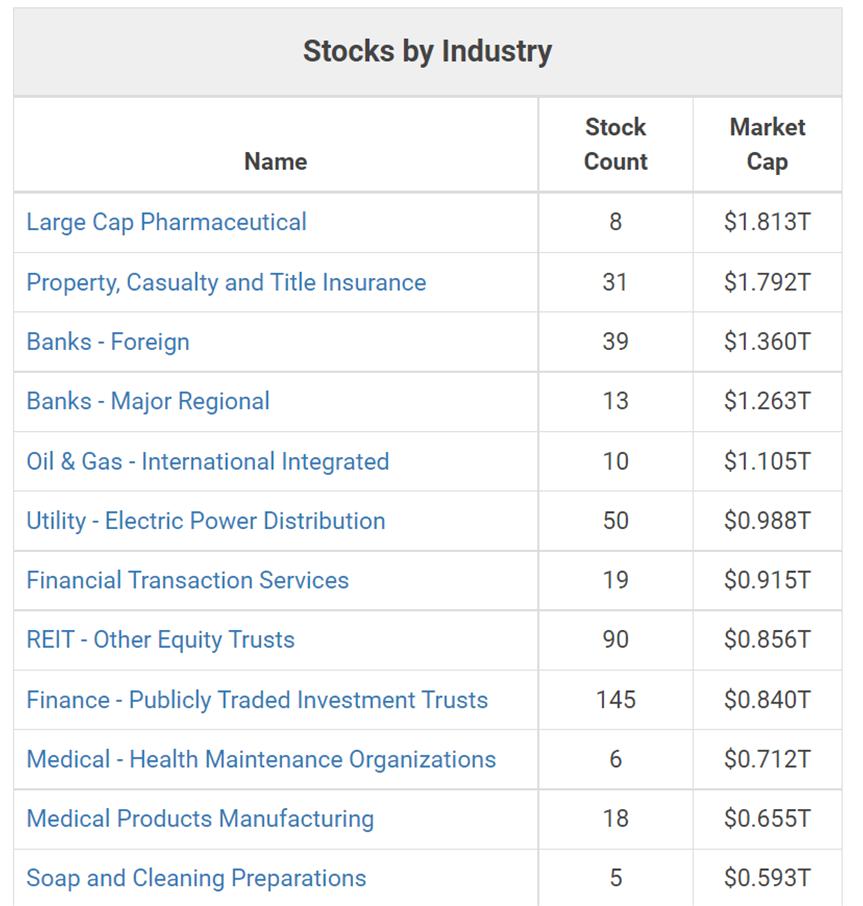

We can scrape this table to get a list of industry groups

In [2]:
url = "https://www.macrotrends.net/stocks/research"
html = requests.request("GET", url)
soup =bs(html.text, "html.parser")
tables = soup.findAll('a', href = True)
industry_groups = []
for a in tables:
    if "/stocks/industry/" in a['href']:
        industry_groups.append(a['href'])
industry_groups[0:5]

['/stocks/industry/225/large-cap-pharmaceutical',
 '/stocks/industry/89/property,-casualty-and-title-insurance',
 '/stocks/industry/12/banks---foreign',
 '/stocks/industry/204/banks---major-regional',
 '/stocks/industry/132/oil-gas---international-integrated']

If you click on any industry, e.g. "Large Cap Pharmaceutical" it will redirect to another page

https://www.macrotrends.net/stocks/industry/225/large-cap-pharmaceutical

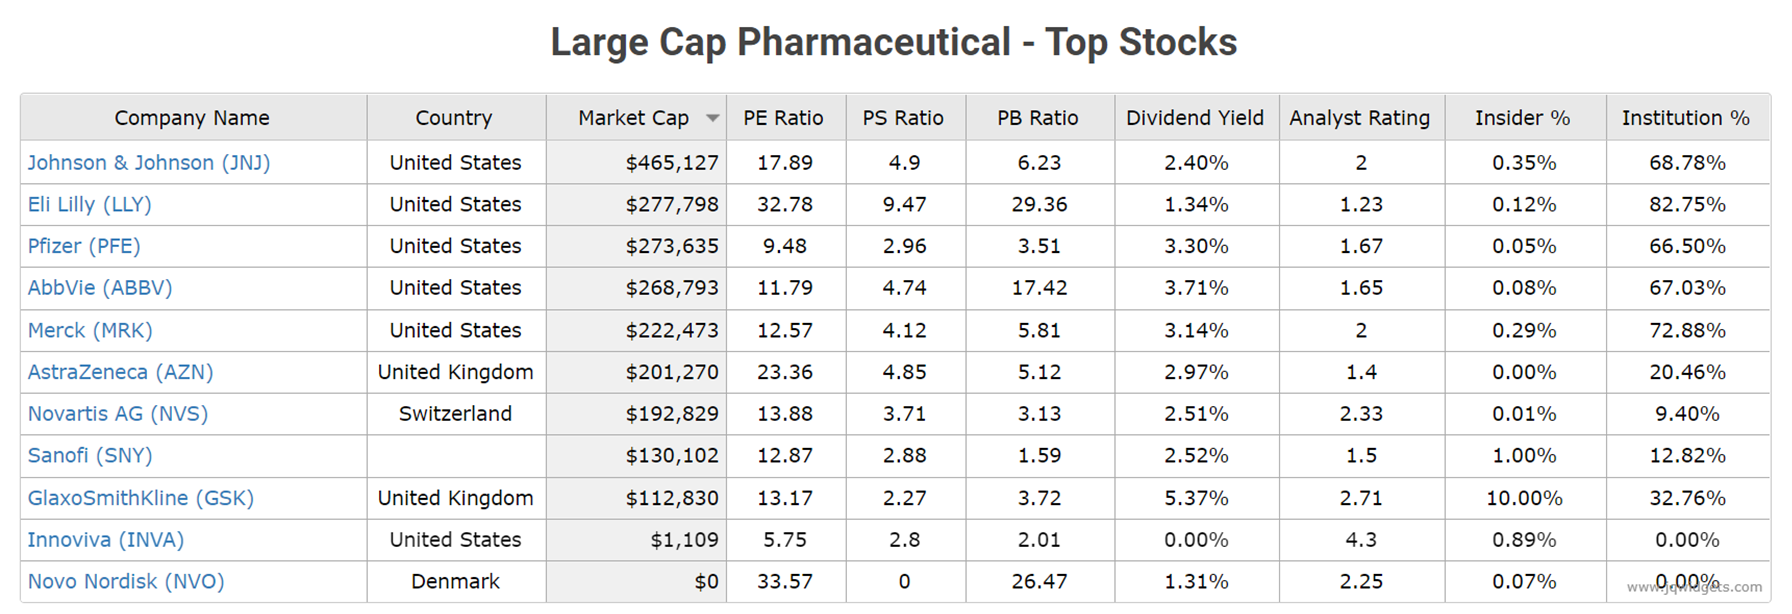



We can scrape this table as well

In [3]:
def get_company_names_info_from_industry_group(industry_group):
    url = "https://www.macrotrends.net" + industry_group
    html = requests.request("GET", url)
    soup =bs(html.text, "html.parser")
    print(url)
    for j in soup.findAll("script"):
        if j.string is not None:
            if "var data" in j.string:
                var_data = j.string
    m = re.findall("\[\{.*\}\]", var_data)
    comp_names_df = pd.DataFrame.from_records(json.loads(m[0]))
    return comp_names_df

In [4]:
pharma_companies = get_company_names_info_from_industry_group(industry_groups[0])
pharma_companies

https://www.macrotrends.net/stocks/industry/225/large-cap-pharmaceutical


,ticker,zacks_x_ind_desc,comp_name,comp_name_2,country_code,market_val,pe_ratio_12m,price_per_sales,price_book,div_yield,cons_recom_curr,held_by_insiders_pct,held_by_institutions_pct,link
0,JNJ,Large Cap Pharmaceutical,johnson-johnson,Johnson & Johnson,United States,464100.38,17.85,4.89,6.21,2.40,2.00,0.35,68.78,<a href='https://www.macrotrends.net/stocks/ch...
1,LLY,Large Cap Pharmaceutical,eli-lilly,Eli Lilly,United States,282102.50,33.28,9.62,29.81,1.32,1.23,0.12,82.75,<a href='https://www.macrotrends.net/stocks/ch...
2,PFE,Large Cap Pharmaceutical,pfizer,Pfizer,United States,276966.84,9.60,2.99,3.55,3.26,1.67,0.05,66.50,<a href='https://www.macrotrends.net/stocks/ch...
3,ABBV,Large Cap Pharmaceutical,abbvie,AbbVie,United States,269941.34,11.84,4.76,17.50,3.69,1.65,0.08,67.03,<a href='https://www.macrotrends.net/stocks/ch...
4,MRK,Large Cap Pharmaceutical,merck,Merck,United States,223433.30,12.63,4.14,5.84,3.12,2.00,0.29,72.88,<a href='https://www.macrotrends.net/stocks/ch...
5,AZN,Large Cap Pharmaceutical,astrazeneca,AstraZeneca,United Kingdom,199441.34,23.15,4.81,5.08,3.00,1.40,0.00,20.46,<a href='https://www.macrotrends.net/stocks/ch...
6,NVS,Large Cap Pharmaceutical,novartis-ag,Novartis AG,Switzerland,191956.94,13.82,3.69,3.11,2.52,2.33,0.01,9.40,<a href='https://www.macrotrends.net/stocks/ch...
7,SNY,Large Cap Pharmaceutical,sanofi,Sanofi,,129899.42,12.85,2.88,1.59,2.52,1.50,1.00,12.82,<a href='https://www.macrotrends.net/stocks/ch...
8,GSK,Large Cap Pharmaceutical,glaxosmithkline,GlaxoSmithKline,United Kingdom,112067.74,13.08,2.25,3.69,5.41,2.71,10.00,32.76,<a href='https://www.macrotrends.net/stocks/ch...
9,INVA,Large Cap Pharmaceutical,innoviva,Innoviva,United States,1072.71,5.57,2.71,1.94,0.00,4.30,0.89,0.00,<a href='https://www.macrotrends.net/stocks/ch...


The table above has the required `ticker` and `comp_name` mapping. 

**NOTE**

This scraping is more complicated than it looks, because the table on the webpage is dynamically generated using an internal javascript at the time of page load. Therefore there is no good way to directly extract that info from the webpage. Ultimately it boils down to the following steps.

1) Identify all `script` objects within the html of the industry group webpage

2) Find the script that contains the object `var data` and extract `var data` using regex

3) Parse `var data` using json.loads

4) Convert `var data` to a dataframe using the `pd.DataFrame.from_records()` method

Armed with the required `ticker` and `comp_name` information, we can now progressively build urls that navigate to each page for that specific metric

In [5]:
# roe_url = "https://www.macrotrends.net/stocks/charts/FICO/fair-isaac/roe"
# roa_url = "https://www.macrotrends.net/stocks/charts/FICO/fair-isaac/roa"
# roi_url = "https://www.macrotrends.net/stocks/charts/FICO/fair-isaac/roi"
# so_url = "https://www.macrotrends.net/stocks/charts/FICO/fair-isaac/shares-outstanding"
# pe_url = "https://www.macrotrends.net/stocks/charts/FICO/fair-isaac/pe-ratio"
# p_fcf_url = "https://www.macrotrends.net/stocks/charts/FICO/fair-isaac/price-fcf"
# gm_url = "https://www.macrotrends.net/stocks/charts/FICO/fair-isaac/gross-margin"
# nm_url = "https://www.macrotrends.net/stocks/charts/FICO/fair-isaac/net-profit-margin"

def get_urls(ticker, comp_name):
    base_url = "https://www.macrotrends.net/stocks/charts/"
    roe_url = base_url + ticker + "/" + comp_name + "/roe"
    roa_url = base_url + ticker + "/" + comp_name + "/roa"
    roi_url = base_url + ticker + "/" + comp_name + "/roi"
    so_url =  base_url + ticker + "/" + comp_name + "/shares-outstanding"
    pe_url =  base_url + ticker + "/" + comp_name +  "/pe-ratio"
    p_fcf_url = base_url + ticker + "/" + comp_name + "/price-fcf"
    gm_url = base_url + ticker + "/" + comp_name + "/gross-margin"
    nm_url = base_url + ticker + "/" + comp_name + "/net-profit-margin"

    return roe_url, roa_url, roi_url, so_url, pe_url, p_fcf_url, gm_url, nm_url

In [6]:
ticker = pharma_companies["ticker"][4]
comp_name = pharma_companies["comp_name"][4]
roe_url, roa_url, roi_url, so_url, pe_url, p_fcf_url, gm_url, nm_url = get_urls(ticker, comp_name)

In [7]:
roe_url

'https://www.macrotrends.net/stocks/charts/MRK/merck/roe'

We should scrape all the company tables once so we don't have to keep scraping the same information over and over.

In [8]:
# all_companies_df = pd.DataFrame()
# for group in industry_groups:
#     all_companies_df = pd.concat([all_companies_df, get_company_names_info_from_industry_group(group)])
# all_companies_df.to_csv('macrotrends data/all_companies_df_from_macrotrends.csv')

Load S&P 500 companies

In [9]:
s_p500 = pd.read_csv('S&P500-Info.csv')
all_companies_df = pd.read_csv('macrotrends data/all_companies_df_from_macrotrends.csv')

Define some custom functions that scrape specific pages for each security

In [10]:
def get_roe_table(url):
    html = requests.request("GET", url)
    soup =bs(html.text, "html.parser")
    tables = soup.findAll("table")
    td_elements = tables[0].findAll("td")
    all_elem = [element.text for element in td_elements]
    Date, TTM_NetIncome, Shareholders_Equity, Return_on_Equity = [], [], [], []
    Date = all_elem[::4]
    TTM_NetIncome = all_elem[1::4]
    Shareholders_Equity = all_elem[2::4]
    Return_on_Equity = all_elem[3::4]
    info_df = pd.DataFrame(list(zip(Date, TTM_NetIncome, Shareholders_Equity, Return_on_Equity)), 
                           columns = ["Date", "TTM_NetIncome", "Shareholders_Equity", "Return_on_Equity"])
    return info_df

def get_roa_table(url):
    html = requests.request("GET", url)
    soup =bs(html.text, "html.parser")
    tables = soup.findAll("table")
    td_elements = tables[0].findAll("td")
    all_elem = [element.text for element in td_elements]
    Date, TTM_NetIncome, Total_Assets, Return_On_Assets = [], [], [], []
    Date = all_elem[::4]
    TTM_NetIncome = all_elem[1::4]
    Total_Assets = all_elem[2::4]
    Return_On_Assets = all_elem[3::4]
    info_df = pd.DataFrame(list(zip(Date, TTM_NetIncome, Total_Assets, Return_On_Assets)), 
                           columns = ["Date", "TTM_NetIncome", "Total_Assets", "Return_On_Assets"])
    return info_df

def get_roi_table(url):
    html = requests.request("GET", url)
    soup =bs(html.text, "html.parser")
    tables = soup.findAll("table")
    td_elements = tables[0].findAll("td")
    all_elem = [element.text for element in td_elements]
    Date, TTM_NetIncome, LT_Investments_Debt, Return_on_Investment = [], [], [], []
    Date = all_elem[::4]
    #TTM_NetIncome = all_elem[1::4]
    LT_Investments_Debt = all_elem[2::4]
    Return_on_Investment = all_elem[3::4]
    info_df = pd.DataFrame(list(zip(Date, LT_Investments_Debt, Return_on_Investment)), 
                           columns = ["Date",  "LT_Investments_Debt", "Return_on_Investment"])
    return info_df


def get_so_table(url):
    html = requests.request("GET", url)
    soup =bs(html.text, "html.parser")
    tables = soup.findAll("table")
    td_elements = tables[1].findAll("td")
    all_elem = [element.text for element in td_elements]
    Date = all_elem[::2]
    Shares_Outstanding = all_elem[1::2]
    if "Millions of Shares" in tables[1].text:
        Shares_Outstanding = [str(x.replace("," , "") + "M") for x in Shares_Outstanding]
    info_df = pd.DataFrame(list(zip(Date, Shares_Outstanding )), 
                           columns = ["Date",  "Shares_Outstanding"])
    return info_df

def get_gm_table(url):
    html = requests.request("GET", url)
    soup =bs(html.text, "html.parser")
    tables = soup.findAll("table")
    td_elements = tables[0].findAll("td")
    all_elem = [element.text for element in td_elements]
    Date = all_elem[::4]
    TTM_Revenue = all_elem[1::4]
    TTM_Gross_Profit = all_elem[2::4]
    Gross_Margin = all_elem[3::4]
    info_df = pd.DataFrame(list(zip(Date, TTM_Revenue, TTM_Gross_Profit, Gross_Margin )), 
                           columns = ["Date",  "TTM_Revenue", "TTM_Gross_Profit", "Gross_Margin"])
    return info_df

def get_nm_table(url):
    html = requests.request("GET", url)
    soup =bs(html.text, "html.parser")
    tables = soup.findAll("table")
    td_elements = tables[0].findAll("td")
    all_elem = [element.text for element in td_elements]
    Date = all_elem[::4]
    TTM_Revenue = all_elem[1::4]
    TTM_NetIncome = all_elem[2::4]
    Net_Margin = all_elem[3::4]
    info_df = pd.DataFrame(list(zip(Date, TTM_Revenue, TTM_NetIncome, Net_Margin)), 
                           columns = ["Date",  "TTM_Revenue", "TTM_NetIncome", "Net_Margin"])
    return info_df


And some other functions to clean up the information for easier plotting

In [11]:
def convert_strings_to_nums(string):
    
    if string == "":
        num = np.nan
        
    #converting billions    
    if "B" in string:
        try:
            s = string.replace("B", "").replace("$", "")
            num = float(s)* 1e9
        except:
            num = np.nan
            
    #converting millions       
    elif "M" in string:
        try:
            s = string.replace("M", "").replace("$", "")
            num = float(s)* 1e6
        except:
            num = np.nan
            
    #converting thousands       
    elif "K" in string:
        try: 
            s = string.replace("K", "").replace("$", "")
            num = float(s)* 1e3
        except:
            num = np.nan
            
    #converting percentages        
    elif "%" in string:
        
        #Handling the edge case when % is an infinite number
        if "inf" in string:
            num = np.inf
        else:
            try:
                s = string.replace("%", "")
                num = float(s)/ 100
            except:
                num = np.nan

    return num    


def find_special_chars(string, special_chars):
    for i in special_chars:
        if i in string:
            return i
    return False

Retrieve each individual table that we need

In [12]:
roe_table = get_roe_table(roe_url)
roi_table = get_roi_table(roi_url)
roa_table = get_roa_table(roa_url)
so_table = get_so_table(so_url)
gm_table = get_gm_table(gm_url)
nm_table = get_nm_table(nm_url)

Create a consolidated table using a series of left joins on the `Date` and other relevant columns

In [13]:
consolidated_table = roe_table.merge(roa_table, on = ["Date", "TTM_NetIncome"]).merge(
                     roi_table, on = ["Date"]).merge(
                     so_table, on = ["Date"], how = 'left').merge(
                     gm_table, on = ["Date"], how = 'left').merge(
                     nm_table,  on = ["Date", "TTM_NetIncome", "TTM_Revenue"], how = 'left')
consolidated_table

,Date,TTM_NetIncome,Shareholders_Equity,Return_on_Equity,Total_Assets,Return_On_Assets,LT_Investments_Debt,Return_on_Investment,Shares_Outstanding,TTM_Revenue,TTM_Gross_Profit,Gross_Margin,Net_Margin
0,2022-03-31,$14.18B,,52.76%,$0.00B,19.57%,,33.51%,2537M,$52.53B,$37.19B,70.80%,27.00%
1,2021-12-31,$13.05B,$38.26B,38.79%,$105.69B,13.71%,$68.95B,22.35%,2538M,$48.70B,$35.08B,72.02%,26.79%
2,2021-09-30,$7.20B,$35.86B,23.65%,$93.49B,7.85%,$58.77B,12.03%,2536M,$45.82B,$31.05B,67.76%,15.71%
3,2021-06-30,$5.57B,$33.39B,19.36%,$90.69B,6.14%,$57.42B,7.71%,2540M,$43.59B,$29.26B,67.12%,12.78%
4,2021-03-31,$7.03B,$27.04B,25.68%,$90.85B,7.75%,$51.04B,9.24%,2541M,$41.54B,$27.57B,66.36%,16.92%
5,2020-12-31,$7.07B,$25.40B,26.00%,$91.59B,7.92%,$50.76B,10.66%,2541M,$41.52B,$27.90B,67.20%,17.02%
6,2020-09-30,$11.52B,$29.27B,42.15%,$89.80B,13.17%,$55.59B,14.30%,2538M,$36.49B,$25.84B,70.83%,31.57%
7,2020-06-30,$10.48B,$27.74B,39.18%,$90.62B,12.21%,$53.90B,14.94%,2536M,$37.96B,$26.33B,69.38%,27.61%
8,2020-03-31,$10.15B,$26.30B,37.95%,$84.91B,12.06%,$47.94B,17.28%,2547M,$40.36B,$28.09B,69.59%,25.14%
9,2019-12-31,$9.84B,$26.00B,36.34%,$84.40B,11.79%,$48.74B,15.91%,2580M,$39.12B,$27.11B,69.29%,25.16%


Clean up the information in the table, e.g. 
- converting information expressed in currency units `$25.53B` to a number
- converting % information `14.43%` to a number

In [14]:
a = consolidated_table.columns[consolidated_table.columns != "Date"]
consolidated_table[a] = consolidated_table[a].applymap(lambda x :convert_strings_to_nums(x))
consolidated_table["Date"] = pd.to_datetime(consolidated_table["Date"])
consolidated_table.insert(1, "Ticker", ticker)
consolidated_table.insert(2, "Company", comp_name)
consolidated_table

,Date,Ticker,Company,TTM_NetIncome,Shareholders_Equity,Return_on_Equity,Total_Assets,Return_On_Assets,LT_Investments_Debt,Return_on_Investment,Shares_Outstanding,TTM_Revenue,TTM_Gross_Profit,Gross_Margin,Net_Margin
0,2022-03-31,MRK,merck,1.418000e+10,NaN,0.5276,0.000000e+00,0.1957,NaN,0.3351,2.537000e+09,5.253000e+10,3.719000e+10,0.7080,0.2700
1,2021-12-31,MRK,merck,1.305000e+10,3.826000e+10,0.3879,1.056900e+11,0.1371,6.895000e+10,0.2235,2.538000e+09,4.870000e+10,3.508000e+10,0.7202,0.2679
2,2021-09-30,MRK,merck,7.200000e+09,3.586000e+10,0.2365,9.349000e+10,0.0785,5.877000e+10,0.1203,2.536000e+09,4.582000e+10,3.105000e+10,0.6776,0.1571
3,2021-06-30,MRK,merck,5.570000e+09,3.339000e+10,0.1936,9.069000e+10,0.0614,5.742000e+10,0.0771,2.540000e+09,4.359000e+10,2.926000e+10,0.6712,0.1278
4,2021-03-31,MRK,merck,7.030000e+09,2.704000e+10,0.2568,9.085000e+10,0.0775,5.104000e+10,0.0924,2.541000e+09,4.154000e+10,2.757000e+10,0.6636,0.1692
5,2020-12-31,MRK,merck,7.070000e+09,2.540000e+10,0.2600,9.159000e+10,0.0792,5.076000e+10,0.1066,2.541000e+09,4.152000e+10,2.790000e+10,0.6720,0.1702
6,2020-09-30,MRK,merck,1.152000e+10,2.927000e+10,0.4215,8.980000e+10,0.1317,5.559000e+10,0.1430,2.538000e+09,3.649000e+10,2.584000e+10,0.7083,0.3157
7,2020-06-30,MRK,merck,1.048000e+10,2.774000e+10,0.3918,9.062000e+10,0.1221,5.390000e+10,0.1494,2.536000e+09,3.796000e+10,2.633000e+10,0.6938,0.2761
8,2020-03-31,MRK,merck,1.015000e+10,2.630000e+10,0.3795,8.491000e+10,0.1206,4.794000e+10,0.1728,2.547000e+09,4.036000e+10,2.809000e+10,0.6959,0.2514
9,2019-12-31,MRK,merck,9.840000e+09,2.600000e+10,0.3634,8.440000e+10,0.1179,4.874000e+10,0.1591,2.580000e+09,3.912000e+10,2.711000e+10,0.6929,0.2516


Collect single consolidated table for all SPY companies

In [15]:
import tqdm
SPY_companies = all_companies_df[all_companies_df['ticker'].isin(s_p500['Symbol'])]
SPY_companies

,Unnamed: 0,ticker,zacks_x_ind_desc,comp_name,comp_name_2,country_code,market_val,pe_ratio_12m,price_per_sales,price_book,div_yield,cons_recom_curr,held_by_insiders_pct,held_by_institutions_pct,link
0,0,JNJ,Large Cap Pharmaceutical,johnson-johnson,Johnson & Johnson,United States,464100.38,17.85,4.89,6.21,2.40,2.00,0.35,68.78,<a href='https://www.macrotrends.net/stocks/ch...
1,1,LLY,Large Cap Pharmaceutical,eli-lilly,Eli Lilly,United States,282102.50,33.28,9.62,29.81,1.32,1.23,0.12,82.75,<a href='https://www.macrotrends.net/stocks/ch...
2,2,PFE,Large Cap Pharmaceutical,pfizer,Pfizer,United States,276966.84,9.60,2.99,3.55,3.26,1.67,0.05,66.50,<a href='https://www.macrotrends.net/stocks/ch...
3,3,ABBV,Large Cap Pharmaceutical,abbvie,AbbVie,United States,269941.34,11.84,4.76,17.50,3.69,1.65,0.08,67.03,<a href='https://www.macrotrends.net/stocks/ch...
4,4,MRK,Large Cap Pharmaceutical,merck,Merck,United States,223433.30,12.63,4.14,5.84,3.12,2.00,0.29,72.88,<a href='https://www.macrotrends.net/stocks/ch...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6033,0,CTAS,Uniforms & Related Apparel,cintas,Cintas,United States,39286.66,34.81,5.16,12.09,0.99,1.75,14.90,65.09,<a href='https://www.macrotrends.net/stocks/ch...
6078,0,ADI,Semiconductor - Analog & Mixed,analog-devices,Analog Devices,United States,81705.17,22.53,9.68,2.18,1.95,1.59,0.47,86.15,<a href='https://www.macrotrends.net/stocks/ch...
6079,1,NXPI,Semiconductor - Analog & Mixed,nxp-semiconductors,NXP Semiconductors,Netherlands,46626.29,16.94,4.01,6.90,1.90,2.15,0.11,89.03,<a href='https://www.macrotrends.net/stocks/ch...
6080,2,MCHP,Semiconductor - Analog & Mixed,microchip-technology,Microchip Technology,United States,37562.75,17.83,5.83,6.46,1.50,1.59,2.03,89.36,<a href='https://www.macrotrends.net/stocks/ch...


In [16]:
consolidated_s_p_500_table = pd.DataFrame()
counter = 0
for ticker, comp_name in zip(SPY_companies['ticker'], SPY_companies['comp_name']):
    counter += 1
    print(counter, ticker, comp_name)
    try:
        roe_url, roa_url, roi_url, so_url, pe_url, p_fcf_url, gm_url, nm_url = get_urls(ticker, comp_name)
        roe_table = get_roe_table(roe_url)
        roi_table = get_roi_table(roi_url)
        roa_table = get_roa_table(roa_url)
        so_table = get_so_table(so_url)
        gm_table = get_gm_table(gm_url)
        nm_table = get_nm_table(nm_url)
        consolidated_table = roe_table.merge(roa_table, on = ["Date", "TTM_NetIncome"]).merge(
                             roi_table, on = ["Date"]).merge(
                             so_table, on = ["Date"], how = 'left').merge(
                             gm_table, on = ["Date"], how = 'left').merge(
                             nm_table,  on = ["Date", "TTM_NetIncome", "TTM_Revenue"], how = 'left')
        a = consolidated_table.columns[consolidated_table.columns != "Date"]
        consolidated_table[a] = consolidated_table[a].applymap(lambda x :convert_strings_to_nums(x))
        consolidated_table["Date"] = pd.to_datetime(consolidated_table["Date"])
        consolidated_table.insert(1, "Ticker", ticker)
        consolidated_table.insert(2, "Company", comp_name)
        consolidated_s_p_500_table = pd.concat([consolidated_s_p_500_table, consolidated_table])
    except:
        print(f"Couldn't generate table for {counter}, {ticker}, {comp_name}")

1 JNJ johnson-johnson
2 LLY eli-lilly
3 PFE pfizer
4 ABBV abbvie
5 MRK merck
6 BRK.B berkshire-hathaway
7 CB chubb
8 PGR progressive
9 TRV travelers
10 ALL allstate
11 CINF cincinnati-financial
12 WRB wr-berkley
13 RE everest-re-group
14 JPM jpmorgan-chase
15 BAC bank-of-america
16 WFC wells-fargo
17 C citigroup
18 USB us-bancorp
19 PNC pnc-financial-services
20 TFC truist-financial
21 BK bank-of-new-york-mellon
22 STT state-street
23 FITB fifth-third-bancorp
24 MTB m-t-bank
25 NTRS northern-trust
26 KEY keycorp
27 CMA comerica
28 XOM exxon
29 CVX chevron
30 NEE nextera-energy
31 DUK duke-energy
32 SO southern
33 D dominion-energy
34 AEP american-electric-power
35 EXC exelon
36 XEL xcel-energy
37 PEG public-service-enterprise-group
38 ED consolidated-edison-inc
39 WEC wec-energy
40 ES eversource-energy
41 EIX edison
42 DTE dte-energy
43 FE firstenergy
44 ETR entergy
45 AEE ameren
46 PPL ppl
47 CMS cms-energy
48 CNP centerpoint-energy
49 LNT alliant-energy
50 AES aes
51 NI nisource
52 N

375 WYNN wynn-resorts
376 PENN penn-national-gaming
377 AMCR amcor
378 PKG packaging-of-america
379 SEE sealed-air
380 ANET arista-networks
381 GLW corning
382 J jacobs-engineering-group
383 PWR quanta-services
384 HWM howmet-aerospace
385 WY weyerhaeuser
386 JCI johnson-controls
387 NLOK nortonlifelock
388 ALLE allegion
389 ORLY oreilly-automotive
390 AZO autozone
391 KMX carmax
392 AAP advance-auto-parts
393 MTD mettler-toledo
394 WAT waters
395 PKI perkinelmer
396 VMC vulcan-materials
397 MLM martin-marietta-materials
398 TEL te-connectivity
399 KLAC kla
400 CARR carrier-global
401 GRMN garmin
402 TRMB trimble
403 TSN tyson-foods
404 HRL hormel-foods
405 VFC vf
406 RL ralph-lauren
407 UAA under-armour
408 UA under-armour
409 PVH pvh
410 DGX quest-diagnostics
411 DVA davita
412 TPR tapestry
413 CME cme-group
414 ICE intercontinental-exchange
415 NDAQ nasdaq
416 MKTX marketaxess-holdings
417 AWK american-water-works
418 EXPD expeditors-of-washington
419 CHRW ch-robinson-worldwide
420 

In [17]:
consolidated_s_p_500_table.to_csv('macrotrends data/consolidated_s_p_500_table.csv')
consolidated_s_p_500_table.head()

,Date,Ticker,Company,TTM_NetIncome,Shareholders_Equity,Return_on_Equity,Total_Assets,Return_On_Assets,LT_Investments_Debt,Return_on_Investment,Shares_Outstanding,TTM_Revenue,TTM_Gross_Profit,Gross_Margin,Net_Margin
0,2022-03-31,JNJ,johnson-johnson,19830000000.0,74710000000.0,0.2749,178360000000.0,0.1108,103560000000.0,0.208,2667000000.0,94880000000.0,64489999999.999992,0.6797,0.209
1,2021-12-31,JNJ,johnson-johnson,20880000000.0,74020000000.0,0.2986,182020000000.0,0.1176,104010000000.0,0.2275,2674000000.0,93780000000.0,63920000000.0,0.6816,0.2226
2,2021-09-30,JNJ,johnson-johnson,17880000000.0,70270000000.0,0.2659,179230000000.0,0.1017,100400000000.0,0.1997,2675000000.0,91450000000.0,61730000000.0,0.6751,0.1955
3,2021-06-30,JNJ,johnson-johnson,17770000000.0,69580000000.0,0.2701,176440000000.0,0.1023,99890000000.0,0.2071,2672000000.0,89190000000.0,59750000000.0,0.67,0.1992
4,2021-03-31,JNJ,johnson-johnson,15120000000.0,65830000000.0,0.2357,172560000000.0,0.0894,96100000000.0,0.1847,2673000000.0,84210000000.0,55790000000.0,0.6624,0.1795


## Plotting

In [19]:
agg_metrics = ["TTM_NetIncome", 
               "Total_Assets", 
               "Shareholders_Equity", 
               "LT_Investments_Debt", 
               "Shares_Outstanding", 
               "TTM_Revenue",
               "TTM_Gross_Profit"]

ratio_metrics = ["Return_on_Equity", 
                "Return_on_Investment",
                "Gross_Margin",
                "Net_Margin"]

fig = make_subplots(rows=4, cols=2, subplot_titles=agg_metrics)
row = 1
for index, value in enumerate(agg_metrics):
    if index % 2 == 0:
        fig.add_trace(
            go.Bar(x=consolidated_table["Date"], y=consolidated_table[value]),
            row=row, col=1)
    else:
        fig.add_trace(
            go.Bar(x=consolidated_table["Date"], y=consolidated_table[value]),
            row=row, col=2)
        row+=1
    
fig.update_layout(height=1200, width=800, title_text=f"Aggregate metrics for {comp_name.upper()}", showlegend=False)
fig.show()

fig2 = make_subplots(rows=2, cols=2, subplot_titles=ratio_metrics)
row = 1
for index, value in enumerate(ratio_metrics):
    if index % 2 == 0:
        fig2.add_trace(
            go.Bar(x=consolidated_table["Date"], y=consolidated_table[value]),
            row=row, col=1)
    else:
        fig2.add_trace(
            go.Bar(x=consolidated_table["Date"], y=consolidated_table[value]),
            row=row, col=2)
        row+=1
    
fig2.update_layout(height=1200, width=800, title_text=f"Ratio metrics for {comp_name.upper()}", showlegend=False)
fig2.show()